## Apriori algorithm for ARM


In [1]:
#!pip install tensorflow==2.5.3

In [1]:
import time
start = time.time()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from apyori import apriori
#from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.decomposition import NMF
import tensorflow as tf
from sklearn.metrics import roc_auc_score
import seaborn as sns
import re

import warnings
warnings.simplefilter("ignore", UserWarning)


import warnings
warnings.simplefilter("ignore", UserWarning)

sns.set_style("whitegrid")

cols = ['1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','20']

df = pd.read_csv("dataset/shopdata.csv", sep = ",", 
                 names = cols, engine = "python")
data = np.array(df)
t=df.head(5)
t

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,chutney,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,turkey,avocado,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,mineral water,milk,energy bar,whole wheat rice,green tea,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [2]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
count,7501,5747,4389,3345,2529,1864,1369,981,654,395,256,154,87,47,25,8,4,4,3,1
unique,115,117,115,114,110,106,102,98,88,80,66,50,43,28,19,8,3,3,3,1
top,mineral water,mineral water,mineral water,mineral water,green tea,french fries,green tea,green tea,green tea,green tea,low fat yogurt,green tea,green tea,green tea,magazines,chocolate,frozen smoothie,protein bar,cereals,olive oil
freq,577,484,375,201,153,107,96,67,57,31,22,15,8,4,3,1,2,2,1,1


In [3]:
df.shape

(7501, 20)

In [4]:
df.dtypes

1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
15    object
16    object
17    object
18    object
19    object
20    object
dtype: object

In [5]:
df.isnull().sum()

1        0
2     1754
3     3112
4     4156
5     4972
6     5637
7     6132
8     6520
9     6847
10    7106
11    7245
12    7347
13    7414
14    7454
15    7476
16    7493
17    7497
18    7497
19    7498
20    7500
dtype: int64

In [6]:
# check corresponding values
correlation = df.corr()
correlation

""


In [8]:
def get_unique_items(data):
    ncol = data.shape[1]
    items = set()
    for c in range(ncol):
        items = items.union(data[:,c])
    items = np.array(list(items))
    items = items[items != np.array(None)]

    return np.unique(items)

In [9]:
def get_onehot_items(data,unique_items):
    onehot_items = np.zeros((len(data),len(unique_items)),dtype = np.int)
    for i, r in enumerate(data):
        for j, c in enumerate(unique_items):
            onehot_items[i,j] = int(c in r)
            
    return onehot_items

In [11]:
def get_items_from_ohe(ohe,unique_items):
    return unique_items[np.flatnonzero(ohe)]

unique_items = get_unique_items(data)
onehot_items = np.array(get_onehot_items(data, unique_items))
unique_items

array([' asparagus', 'almonds', 'antioxydant juice', 'asparagus',
       'avocado', 'babies food', 'bacon', 'barbecue sauce', 'black tea',
       'blueberries', 'body spray', 'bramble', 'brownies', 'bug spray',
       'burger sauce', 'burgers', 'butter', 'cake', 'candy bars',
       'carrots', 'cauliflower', 'cereals', 'champagne', 'chicken',
       'chili', 'chocolate', 'chocolate bread', 'chutney', 'cider',
       'clothes accessories', 'cookies', 'cooking oil', 'corn',
       'cottage cheese', 'cream', 'dessert wine', 'eggplant', 'eggs',
       'energy bar', 'energy drink', 'escalope', 'extra dark chocolate',
       'flax seed', 'french fries', 'french wine', 'fresh bread',
       'fresh tuna', 'fromage blanc', 'frozen smoothie',
       'frozen vegetables', 'gluten free bar', 'grated cheese',
       'green beans', 'green grapes', 'green tea', 'ground beef', 'gums',
       'ham', 'hand protein bar', 'herb & pepper', 'honey', 'hot dogs',
       'ketchup', 'light cream', 'light mayo', 

In [12]:

n = 15
item_counts = (onehot_items != 0).sum(0)
items_max_args = item_counts.argsort()[-n:][::-1]
ic = pd.DataFrame({"Items":unique_items[items_max_args], "Frequency":item_counts[items_max_args]})

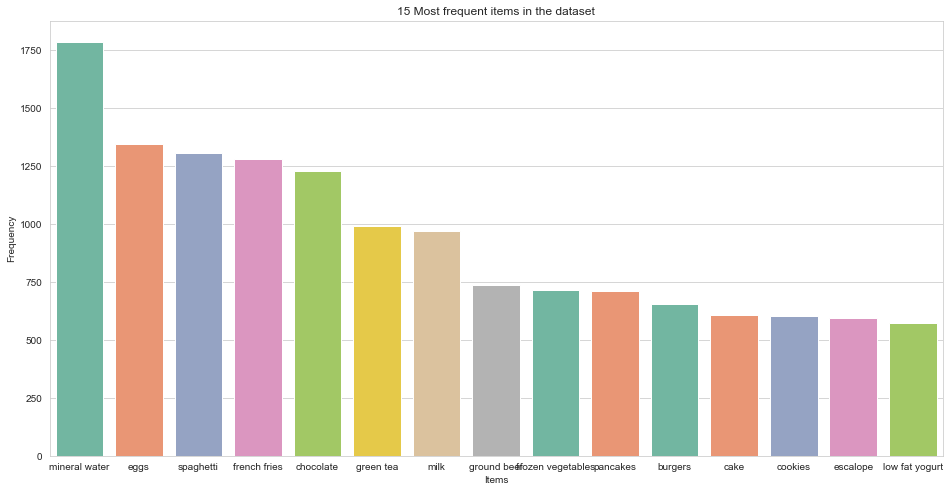

In [13]:

fig = plt.figure(figsize = (16,8))
sns.barplot(x="Items", y="Frequency", data=ic, palette=sns.color_palette("Set2", 10))
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.title(str(n) + " Most frequent items in the dataset")
plt.show()

In [16]:
records = []
df = pd.read_csv("dataset/shopdata.csv", sep = ",", names = cols, engine = "python")
for i in range(0, len(df)):
    records.append([str(df.values[i,j]) for j in range(0, 20)])

In [17]:
association_rules = apriori(records,min_support=0.004, min_confidence=0.2, min_lift=3, min_length=2)
association_results = list(association_rules)
result_apriory = pd.DataFrame()
for item in association_results:
    if len((list(item.ordered_statistics[0].items_base)))< 2:
       continue
    
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    item1=list(item.ordered_statistics[0].items_base)
    if 'nan' in item1: item1.remove('nan')
    if 'None' in item1: item1.remove('None')
    item2=list(item.ordered_statistics[0].items_add)
    if 'nan' in item2: item2.remove('nan')
    if 'None' in item2: item2.remove('None')
    
    print("Rule: " + str(item1) + " -> " + str(item2))

    #second index of the inner list
    print("Support: " + str(item[1]))
    #third index of the list located at 0th 
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    #conviction
    sup=re.sub("[^\d\.]", "", str(item[1]))
    confd=re.sub("[^\d\.]", "", str(item[2][0][2]))
    Convicn=(1-float(sup))/(1-float(confd))
    print("Conviction: " + str(Convicn))
    print("=====================================")
    #print(str(item[2][0][4]))
        
    temp = pd.DataFrame({'item1':[ item1], 'item2': [item2], 'Support': (item[1]), 'Confidence': (item[2][0][2]), 'Lift': (item[2][0][3]), 'Conviction':(Convicn)})
    result_apriory = pd.concat([result_apriory, temp])

result_apriory.to_csv("result_apriory.csv", sep=',')    



Rule: ['chocolate', 'frozen vegetables'] -> ['shrimp']
Support: 0.005332622317024397
Confidence: 0.23255813953488375
Lift: 3.2545123221103784
Conviction: 1.2960817345566045
Rule: ['ground beef', 'cooking oil'] -> ['spaghetti']
Support: 0.004799360085321957
Confidence: 0.5714285714285714
Lift: 3.2819951870487856
Conviction: 2.3221348264675816
Rule: ['ground beef', 'eggs'] -> ['herb & pepper']
Support: 0.0041327822956939075
Confidence: 0.2066666666666667
Lift: 4.178454627133872
Conviction: 1.2552948122323186
Rule: ['spaghetti', 'frozen vegetables'] -> ['ground beef']
Support: 0.008665511265164644
Confidence: 0.31100478468899523
Lift: 3.165328208890303
Conviction: 1.4388118621220873
Rule: ['milk', 'frozen vegetables'] -> ['olive oil']
Support: 0.004799360085321957
Confidence: 0.20338983050847456
Lift: 3.088314005352364
Conviction: 1.2492944203184255
Rule: ['tomatoes', 'milk'] -> ['frozen vegetables']
Support: 0.0041327822956939075
Confidence: 0.29523809523809524
Lift: 3.0973160173160172
C

In [18]:
end = time.time() 
print("Time consumed in working of Apriori Algorithm: ",end - start)

Time consumed in working of Apriori Algorithm:  191.96376037597656


### now using the set of rules generated by the algorithm

In [19]:
ndf = pd.read_csv("result_apriory.csv", engine = "python")
ndf = ndf.drop('Unnamed: 0', 1)
new_data = np.array(ndf)
re=ndf.head(5)
re

,item1,item2,Support,Confidence,Lift,Conviction
0,"['chocolate', 'frozen vegetables']",['shrimp'],0.005333,0.232558,3.254512,1.296082
1,"['ground beef', 'cooking oil']",['spaghetti'],0.004799,0.571429,3.281995,2.322135
2,"['ground beef', 'eggs']",['herb & pepper'],0.004133,0.206667,4.178455,1.255295
3,"['spaghetti', 'frozen vegetables']",['ground beef'],0.008666,0.311005,3.165328,1.438812
4,"['milk', 'frozen vegetables']",['olive oil'],0.004799,0.203390,3.088314,1.249294


In [20]:
ndf

,item1,item2,Support,Confidence,Lift,Conviction
0,"['chocolate', 'frozen vegetables']",['shrimp'],0.005333,0.232558,3.254512,1.296082
1,"['ground beef', 'cooking oil']",['spaghetti'],0.004799,0.571429,3.281995,2.322135
2,"['ground beef', 'eggs']",['herb & pepper'],0.004133,0.206667,4.178455,1.255295
3,"['spaghetti', 'frozen vegetables']",['ground beef'],0.008666,0.311005,3.165328,1.438812
4,"['milk', 'frozen vegetables']",['olive oil'],0.004799,0.203390,3.088314,1.249294
5,"['tomatoes', 'milk']",['frozen vegetables'],0.004133,0.295238,3.097316,1.413055
6,"['shrimp', 'mineral water']",['frozen vegetables'],0.007199,0.305085,3.200616,1.428665
7,"['spaghetti', 'frozen vegetables']",['olive oil'],0.005733,0.205742,3.124024,1.251819
8,"['spaghetti', 'frozen vegetables']",['shrimp'],0.005999,0.215311,3.013149,1.266745
9,"['spaghetti', 'frozen vegetables']",['tomatoes'],0.006666,0.239234,3.498046,1.305703


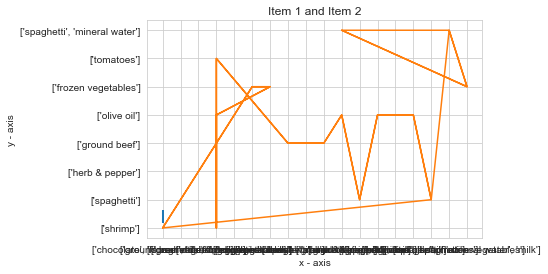

In [27]:
plt.plot(ndf.Support, ndf.Confidence, ndf.item1, ndf.item2)
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title('Item 1 and Item 2')
 
# function to show the plot
plt.show()